### Import libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast

from scipy.stats import mannwhitneyu, kendalltau
from collections import defaultdict
from collections import Counter
from datetime import datetime

sns.set(style="whitegrid")

### Read dataframe

In [2]:
## Uncomment these lines if you want to test with my dataset
# df = pd.read_csv("../data/datasets/dataset_phenomena_cleaned.csv")
# df.drop('phenomena', axis=1, inplace=True)
# df.rename({'clean_processed_phenomena':'phenomena'}, axis=1, inplace=True)

df = pd.read_excel("../data/datasets/dataset_backup.xlsx")
df.rename({'date':'Luna/Zi',
           'County':'county',
           'pm10_quality':'GRAV. 10 - PM 10_Valoare [µg/m³]',
           'air_pressure':'MTX - Presiunea aerului_Valoare [mbar]',
           'temperature':'MTX - Temperatura aer_Valoare [°C]',
           'humidity':'MTX - Umiditate relativa_Valoare [%]', 
          }, axis=1, inplace=True)


df['Luna/Zi'] = pd.to_datetime(df['Luna/Zi'])
df['Luna/Zi'] = df['Luna/Zi'].dt.strftime('%d-%m-%Y')
df['phenomena'] = df['phenomena'].apply(ast.literal_eval)

In [3]:
df.head()

,date,region,phenomena,county,pm10_quality,air_pressure,temperature,humidity
0,2009-02-19,Banat,"['Snow', 'Wind']",TM,51.630000,995.400,-4.095,85.50
1,2009-02-19,Dobrogea,"['Rain', 'Sleet', 'Wind', 'Snow', 'Flood', 'Fog']",CT,21.520000,1005.875,6.745,96.75
2,2009-02-19,Moldova,"['Snow', 'Frost', 'Rain', 'Sleet', 'Wind', 'Fl...",IS,44.600000,1010.700,-0.935,99.00
3,2009-02-19,Muntenia,"['Snow', 'Sleet', 'Rain', 'Wind', 'Flood', 'Fr...",B,34.428571,998.880,0.252,86.20
4,2009-02-20,Moldova,"['Wind', 'Snow']",IS,46.050000,1014.100,-1.615,99.50


### Check distributions

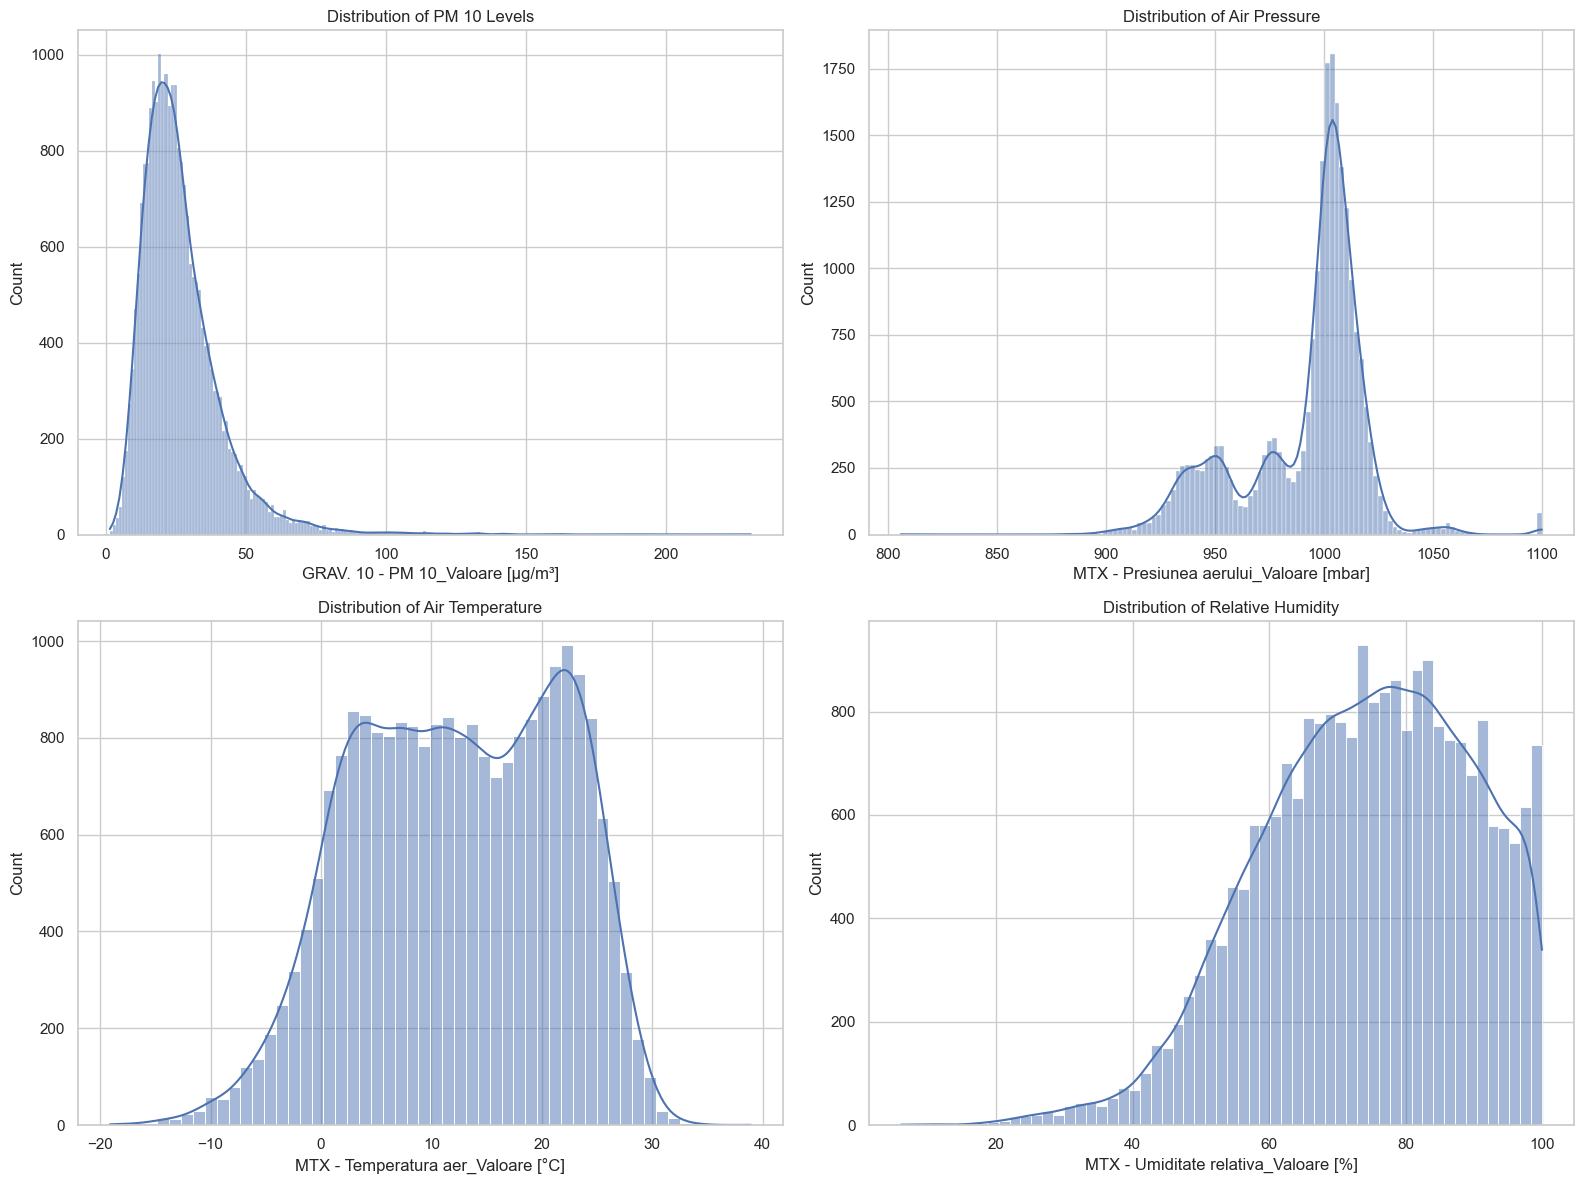

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.histplot(df['GRAV. 10 - PM 10_Valoare [µg/m³]'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of PM 10 Levels')

sns.histplot(df['MTX - Presiunea aerului_Valoare [mbar]'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Air Pressure')

sns.histplot(df['MTX - Temperatura aer_Valoare [°C]'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Air Temperature')

sns.histplot(df['MTX - Umiditate relativa_Valoare [%]'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Relative Humidity')

plt.tight_layout()
plt.show()

Distribution of Variables:
- PM 10 Levels: The distribution shows some skewness, and it appears that most of the PM 10 levels are concentrated around 20-60 µg/m³. High PM 10 levels can be a concern for air quality and health.
- Air Pressure: The distribution is more or less normal, centered around 1000 mbar. Fluctuations in air pressure can often be linked to weather phenomena like storms.
- Air Temperature: The distribution is somewhat bimodal, indicating that there could be two dominant temperature ranges. This could correspond to different seasons or specific weather conditions.
- Relative Humidity: The distribution is slightly left-skewed, with most of the data points concentrated around 70-100%. High relative humidity is often associated with rain or other precipitation.

### Analyzing the variables for extreme values and corresponding phenomena

In [7]:
# Filtering the lowest 5% of air pressure values
low_pressure_threshold = df['MTX - Presiunea aerului_Valoare [mbar]'].quantile(0.05)
low_pressure_df = df[df['MTX - Presiunea aerului_Valoare [mbar]'] <= low_pressure_threshold]

# Extracting unique weather phenomena during low air pressure periods
low_pressure_phenomena = [phenomenon for sublist in low_pressure_df['phenomena'].tolist() for phenomenon in sublist]
unique_low_pressure_phenomena = set(low_pressure_phenomena)

# Counting the occurrences of each phenomenon
low_pressure_phenomena_count = {phenomenon: low_pressure_phenomena.count(phenomenon) for phenomenon in unique_low_pressure_phenomena}

# Sorting by count
sorted_low_pressure_phenomena = {k: v for k, v in sorted(low_pressure_phenomena_count.items(), key=lambda item: item[1], reverse=True)}
sorted_low_pressure_phenomena_10 = {k: sorted_low_pressure_phenomena[k] for k in list(sorted_low_pressure_phenomena)[:10]}
sorted_low_pressure_phenomena_10

{'Snow': 454,
 'Rain': 337,
 'Wind': 276,
 'Lightning': 232,
 'Hail': 217,
 'Showers': 215,
 'Sleet': 214,
 'Blizzard': 197,
 'Whirlwind': 182,
 'Storm': 104}

Low Air Pressure:

- Snowfalls: Snow events like are frequent during low air pressure, which indicates that winter storms are prevalent.
- Hail: Hail events are also frequent, which could suggest the occurrence of severe storms.
- Blizzard: This is another indicator of severe winter weather.
- Rain: Rain is also commonly observed, as expected.
- Sleet: This usually happens in transitional weather, either moving from snowy to rainy conditions or vice versa.
- Blizzard: We do see "blizzard" among the phenomena, though it's not the most frequent.
- The above phenomena indeed confirm that low air pressure is often associated with severe weather conditions like blizzards, and hail, which aligns well with common meteorological knowledge.

In [8]:
# Filtering the highest 5% of PM 10 levels
high_pm10_threshold = df['GRAV. 10 - PM 10_Valoare [µg/m³]'].quantile(0.95)
high_pm10_df = df[df['GRAV. 10 - PM 10_Valoare [µg/m³]'] >= high_pm10_threshold]

# Extracting unique weather phenomena during high PM 10 levels periods
high_pm10_phenomena = [phenomenon for sublist in high_pm10_df['phenomena'].tolist() for phenomenon in sublist]
unique_high_pm10_phenomena = set(high_pm10_phenomena)

# Counting the occurrences of each phenomenon
high_pm10_phenomena_count = {phenomenon: high_pm10_phenomena.count(phenomenon) for phenomenon in unique_high_pm10_phenomena}

# Sorting by count
sorted_high_pm10_phenomena = {k: v for k, v in sorted(high_pm10_phenomena_count.items(), key=lambda item: item[1], reverse=True)}

# Top 10 most frequent phenomena during high PM 10 levels
top_10_high_pm10_phenomena = dict(list(sorted_high_pm10_phenomena.items())[:10])
top_10_high_pm10_phenomena

{'Rain': 400,
 'Snow': 271,
 'Fog': 249,
 'Sleet': 152,
 'Wind': 144,
 'Frost': 134,
 'Lightning': 80,
 'Good weather': 73,
 'Drizzle': 73,
 'Showers': 71}

High PM 10 Levels:
    
- Rain: Rain is the most frequent phenomenon, which may help to settle particulate matter but could also indicate that rain is not effectively clearing the air.
- Fog: Fog may trap pollutants close to the ground, leading to high PM 10 levels.
- Snowfalls: Snow may also trap particulates.
- Frost: Cold temperatures may result in stagnant air, trapping pollutants.
- Sleet: Similar to snow, sleet may trap particulates.

In [9]:
# Filtering the highest and lowest 5% of air temperature values
high_temp_threshold = df['MTX - Temperatura aer_Valoare [°C]'].quantile(0.95)
low_temp_threshold = df['MTX - Temperatura aer_Valoare [°C]'].quantile(0.05)
high_temp_df = df[df['MTX - Temperatura aer_Valoare [°C]'] >= high_temp_threshold]
low_temp_df = df[df['MTX - Temperatura aer_Valoare [°C]'] <= low_temp_threshold]

# Extracting unique weather phenomena during high and low temperature periods
high_temp_phenomena = [phenomenon for sublist in high_temp_df['phenomena'].tolist() for phenomenon in sublist]
low_temp_phenomena = [phenomenon for sublist in low_temp_df['phenomena'].tolist() for phenomenon in sublist]
unique_high_temp_phenomena = set(high_temp_phenomena)
unique_low_temp_phenomena = set(low_temp_phenomena)

# Counting the occurrences of each phenomenon
high_temp_phenomena_count = {phenomenon: high_temp_phenomena.count(phenomenon) for phenomenon in unique_high_temp_phenomena}
low_temp_phenomena_count = {phenomenon: low_temp_phenomena.count(phenomenon) for phenomenon in unique_low_temp_phenomena}

# Sorting by count
sorted_high_temp_phenomena = {k: v for k, v in sorted(high_temp_phenomena_count.items(), key=lambda item: item[1], reverse=True)}
sorted_low_temp_phenomena = {k: v for k, v in sorted(low_temp_phenomena_count.items(), key=lambda item: item[1], reverse=True)}

# Top 10 most frequent phenomena during high and low temperature
top_10_high_temp_phenomena = dict(list(sorted_high_temp_phenomena.items())[:10])
top_10_low_temp_phenomena = dict(list(sorted_low_temp_phenomena.items())[:10])
top_10_high_temp_phenomena

{'Heatwave': 851,
 'Hail': 378,
 'Showers': 343,
 'Whirlwind': 329,
 'Storm': 263,
 'Lightning': 251,
 'Rain': 197,
 'Flood': 114,
 'Wind': 103,
 'Atmospheric instability': 51}

In [10]:
top_10_low_temp_phenomena

{'Snow': 692,
 'Frost': 502,
 'Blizzard': 214,
 'Fog': 189,
 'Sleet': 174,
 'Wind': 148,
 'Freezing rain': 139,
 'Lightning': 122,
 'Rain': 106,
 'Rime': 40}

High Temperature:
    
- Heatwave: As expected, high temperatures are strongly associated with heatwaves.
- Hail: Unusually, hail is also frequent during high temperatures, possibly indicating abrupt weather changes.
- Showers: These could be thunderstorms or sudden rain showers.
- Storm: High temperatures may lead to the formation of storms.

Low Temperature:
    
- Frost: As expected, frost is the most common phenomenon during low temperatures.
- Snowfalls: Snow is also prevalent, indicating winter conditions.
- Blizzard: Indicates severe winter storms.
- Sleet (Lapoviță): A mix of rain and snow, common in cold conditions.

In [11]:
# Filtering the highest 5% of relative humidity values
high_humidity_threshold = df['MTX - Umiditate relativa_Valoare [%]'].quantile(0.95)
high_humidity_df = df[df['MTX - Umiditate relativa_Valoare [%]'] >= high_humidity_threshold]

# Extracting unique weather phenomena during high humidity periods
high_humidity_phenomena = [phenomenon for sublist in high_humidity_df['phenomena'].tolist() for phenomenon in sublist]
unique_high_humidity_phenomena = set(high_humidity_phenomena)

# Counting the occurrences of each phenomenon
high_humidity_phenomena_count = {phenomenon: high_humidity_phenomena.count(phenomenon) for phenomenon in unique_high_humidity_phenomena}

# Sorting by count
sorted_high_humidity_phenomena = {k: v for k, v in sorted(high_humidity_phenomena_count.items(), key=lambda item: item[1], reverse=True)}

# Top 10 most frequent phenomena during high humidity
top_10_high_humidity_phenomena = dict(list(sorted_high_humidity_phenomena.items())[:10])
top_10_high_humidity_phenomena

{'Rain': 578,
 'Snow': 447,
 'Sleet': 257,
 'Fog': 219,
 'Wind': 157,
 'Drizzle': 138,
 'Blizzard': 105,
 'Freezing rain': 93,
 'Lightning': 69,
 'Frost': 67}

High Relative Humidity:

- Rain: High humidity is naturally associated with rain.
- Snowfalls: Snowfalls are also common, as it occurs in conditions of high moisture.
- Sleet: Indicates a mix of rain and snow.
- Wind: Another snow-related phenomenon.

### Correlation matrix

In [8]:
# Calculating the correlation matrix for numerical variables
correlation_matrix = df[['GRAV. 10 - PM 10_Valoare [µg/m³]', 'MTX - Presiunea aerului_Valoare [mbar]', 
                          'MTX - Temperatura aer_Valoare [°C]', 'MTX - Umiditate relativa_Valoare [%]']].corr()

# Plotting the heatmap for correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

KeyError: "None of [Index(['GRAV. 10 - PM 10_Valoare [µg/m³]',\n       'MTX - Presiunea aerului_Valoare [mbar]',\n       'MTX - Temperatura aer_Valoare [°C]',\n       'MTX - Umiditate relativa_Valoare [%]'],\n      dtype='object')] are in the [columns]"

Observations:

- PM 10 Levels & Air Pressure: A very weak positive correlation (0.0614) suggests that there might be a slight increase in PM 10 levels as air pressure increases, but the correlation is weak and may not be significant.
- PM 10 Levels & Temperature: A weak negative correlation (-0.1169) suggests that higher temperatures might slightly decrease PM 10 levels. However, this correlation is weak, and the relationship is not strongly indicative.
- PM 10 Levels & Humidity: A very weak negative correlation (-0.0695) shows that PM 10 levels might slightly decrease as humidity increases, but again, the correlation is weak and may not imply a significant relationship.
- Temperature & Humidity: A moderate negative correlation (-0.4326) indicates that as temperature increases, humidity tends to decrease, which is a common meteorological observation. The higher magnitude suggests a more noticeable relationship between temperature and humidity compared to the other factors.

### Regional Trends

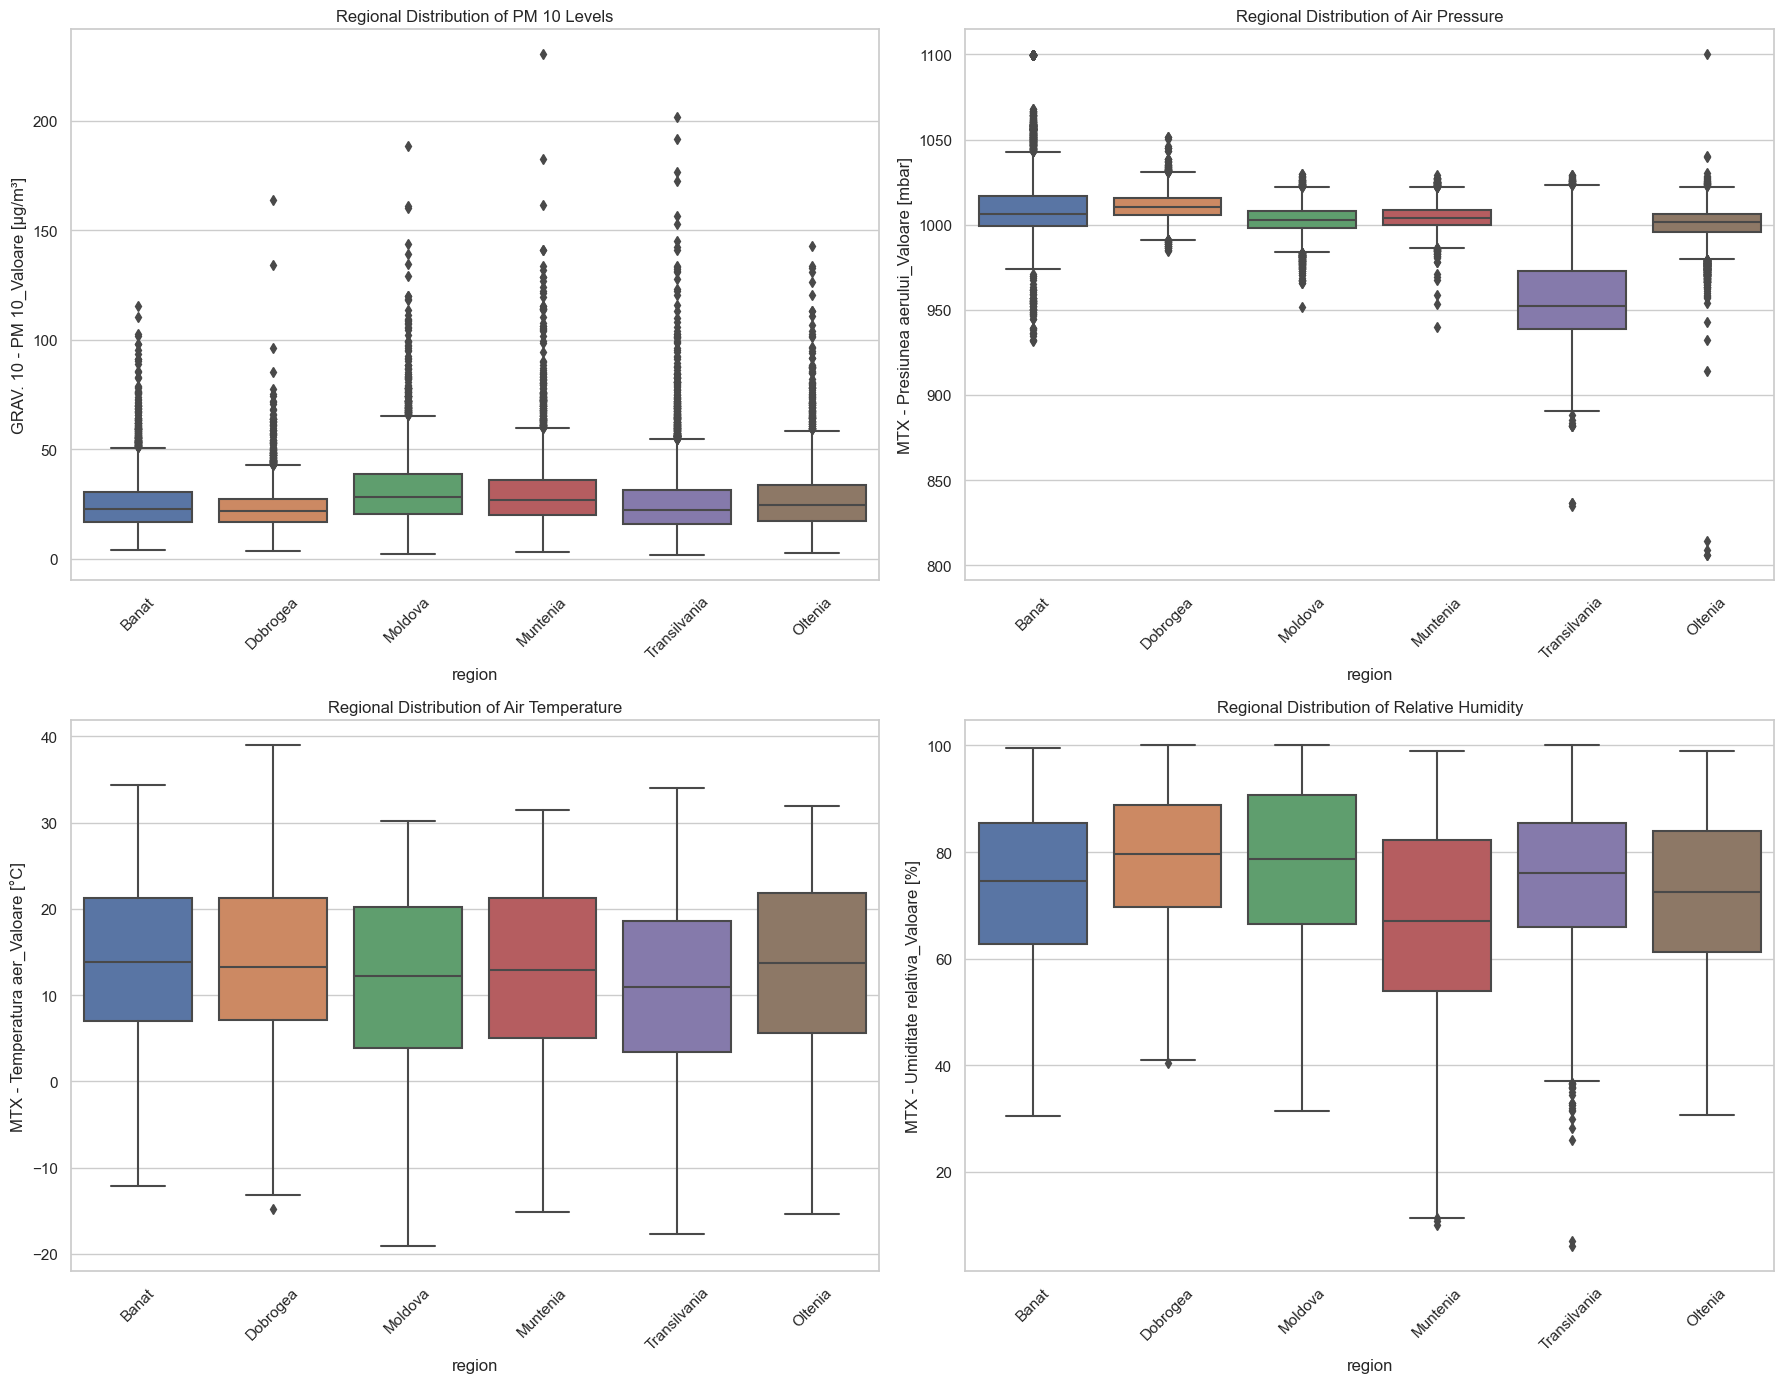

In [13]:
# Creating subplots for regional trends in numerical variables
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Plotting regional distribution for 'GRAV. 10 - PM 10_Valoare [µg/m³]'
sns.boxplot(x='region', y='GRAV. 10 - PM 10_Valoare [µg/m³]', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Regional Distribution of PM 10 Levels')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plotting regional distribution for 'MTX - Presiunea aerului_Valoare [mbar]'
sns.boxplot(x='region', y='MTX - Presiunea aerului_Valoare [mbar]', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Regional Distribution of Air Pressure')
axes[0, 1].tick_params(axis='x', rotation=45)

# Plotting regional distribution for 'MTX - Temperatura aer_Valoare [°C]'
sns.boxplot(x='region', y='MTX - Temperatura aer_Valoare [°C]', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Regional Distribution of Air Temperature')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plotting regional distribution for 'MTX - Umiditate relativa_Valoare [%]'
sns.boxplot(x='region', y='MTX - Umiditate relativa_Valoare [%]', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Regional Distribution of Relative Humidity')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### The most frequent weather phenomen by season over the years

In [157]:
# Extract the year and month for each record
df['Luna/Zi'] = pd.to_datetime(df['Luna/Zi'], dayfirst=True)
df['Year'] = df['Luna/Zi'].dt.year
df['Month'] = df['Luna/Zi'].dt.month

# Define a function to map each month to its corresponding season
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    
# Create a new column for the season
df['Season'] = df['Month'].apply(month_to_season)

In [158]:
cleaned_df = df.copy()

In [159]:
# Reinitialize the dictionary to hold the counts
season_year_phenomena_counts_cleaned = {}

# Loop through each season and year to count the occurrences of each phenomenon
for season in cleaned_df['Season'].unique():
    for year in cleaned_df['Year'].unique():
        # Filter the dataframe for the specific season and year
        filtered_df = df[(df['Season'] == season) & (df['Year'] == year)]
        
        # Initialize a Counter object to count the phenomena
        phenomena_counter = Counter()
        
        # Loop through the filtered dataframe to count each phenomenon
        for phenomena_list_str in filtered_df['phenomena']:
            # Convert the string representation of the list to an actual list
            phenomena_list = phenomena_list_str
            
            # Update the counter
            phenomena_counter.update(phenomena_list)
        
        # Store the top 5 most common phenomena for the specific season and year
        season_year_phenomena_counts_cleaned[(season, year)] = phenomena_counter.most_common(8)

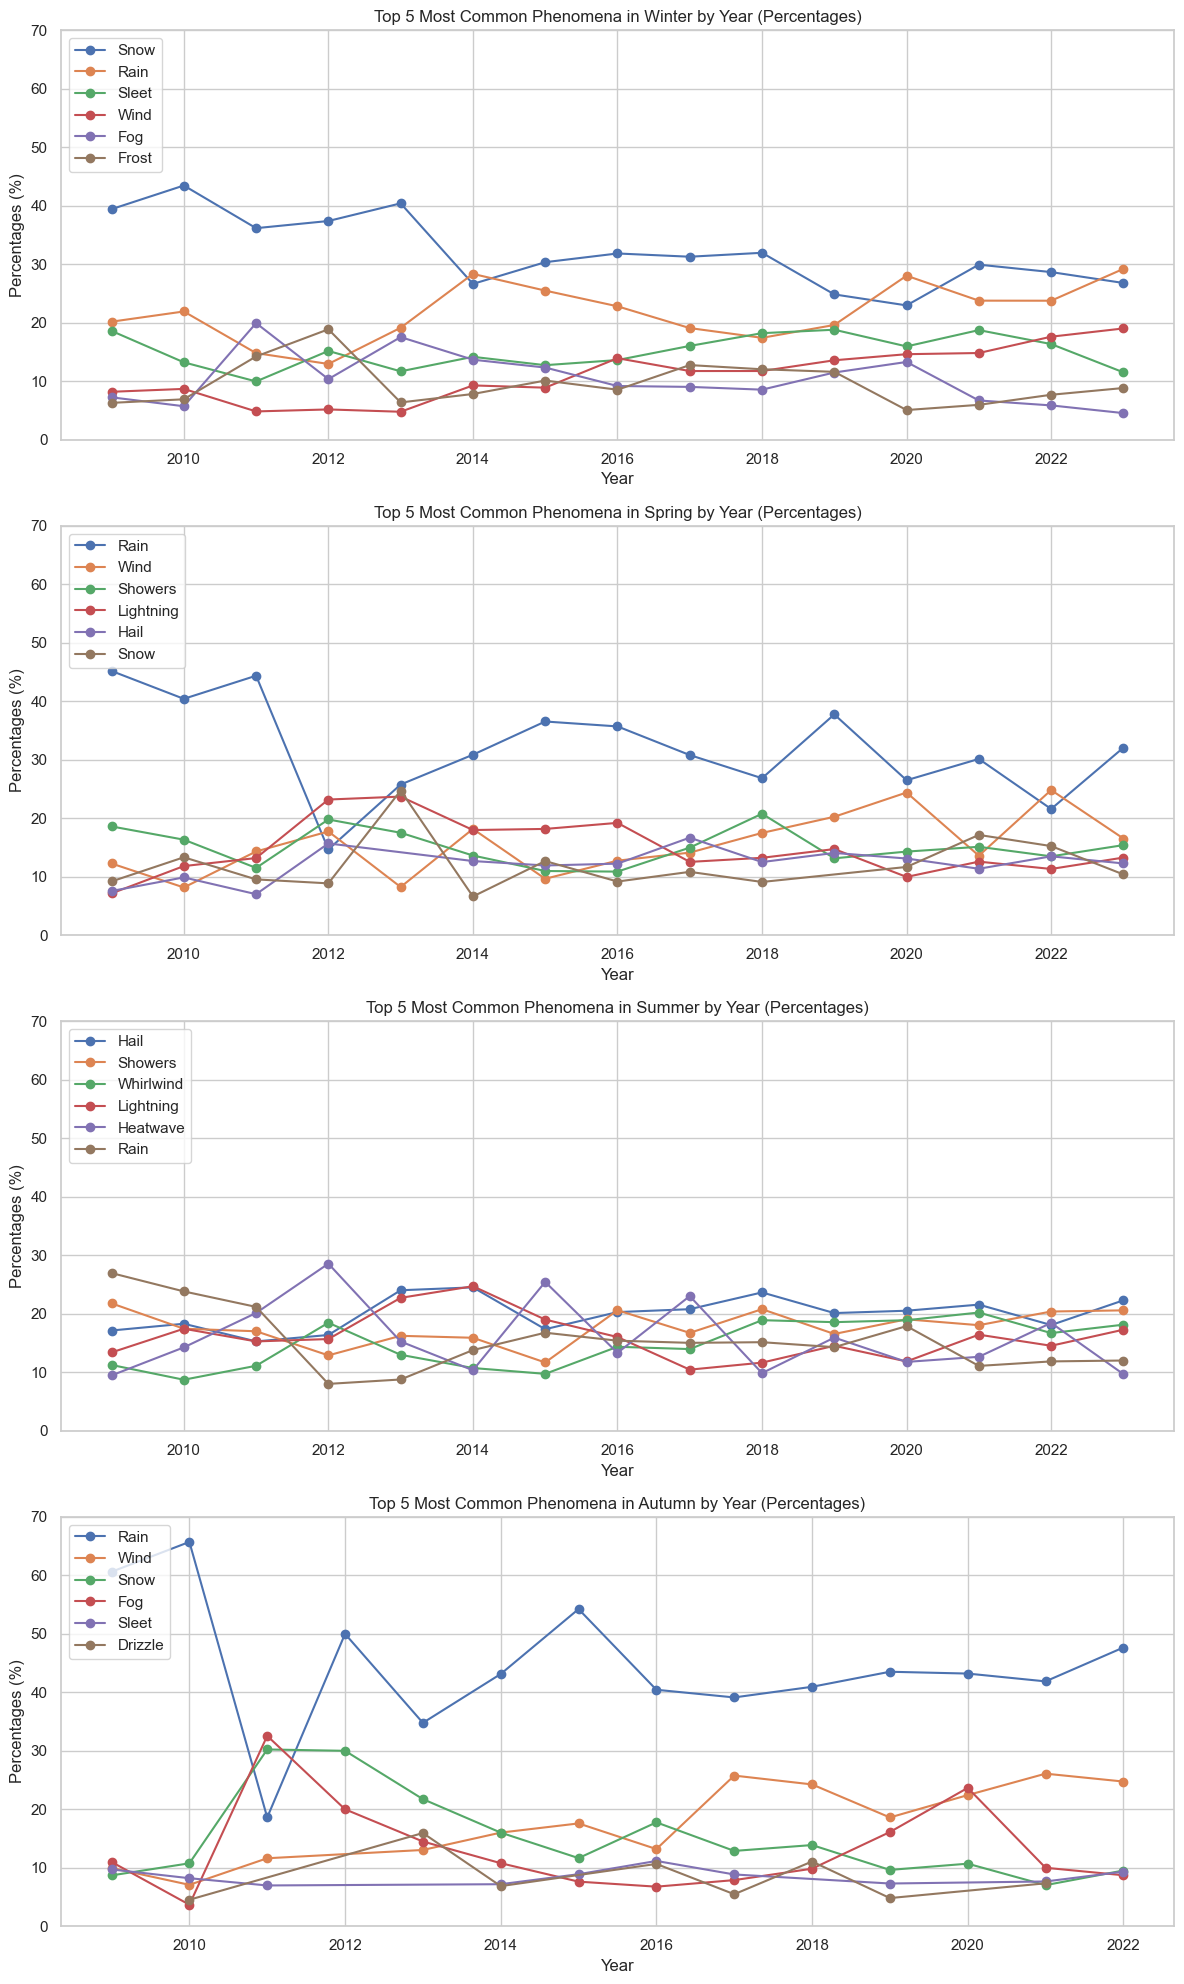

In [160]:
import matplotlib.pyplot as plt

# Initialize the figure and subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 20))
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']

# Loop through each subplot to plot the data for each season
for ax, season in zip(axes, seasons):
    # Get combined counts for all years for the current season
    combined_counts = {}
    for year in sorted(cleaned_df['Year'].unique()):
        for phenomenon, count in season_year_phenomena_counts_cleaned.get((season, year), []):
            combined_counts[phenomenon] = combined_counts.get(phenomenon, 0) + count
    
    # Identify the top 5 phenomena for the current season
    top_5_phenomena = sorted(combined_counts, key=combined_counts.get, reverse=True)[:6]
    
    # Extract data only for these top 5 phenomena
    season_data = {phenomenon: {} for phenomenon in top_5_phenomena}
    for year in sorted(cleaned_df['Year'].unique()):
        for phenomenon, count in season_year_phenomena_counts_cleaned.get((season, year), []):
            if phenomenon in top_5_phenomena:
                season_data[phenomenon][year] = count
    
    # Calculate total occurrences for each year
    total_occurrences = {}
    for phenomenon, year_data in season_data.items():
        for year, count in year_data.items():
            total_occurrences[year] = total_occurrences.get(year, 0) + count
    
    # Plot the data for the current season as percentages
    for phenomenon, year_data in season_data.items():
        years = sorted(year_data.keys())
        percentages = [(year_data.get(year, 0) / total_occurrences.get(year, 1)) * 100 for year in years]
        ax.plot(years, percentages, label=phenomenon, marker='o')
    
    # Configure the subplot
    ax.set_title(f'Top 5 Most Common Phenomena in {season} by Year (Percentages)')
    ax.set_xlabel('Year')
    ax.set_ylabel('Percentages (%)')
    ax.legend(loc='upper left')
    ax.set_ylim(0, 70)  # Set the y-axis limit to 0% to 100%

# Show the plot
plt.tight_layout()
plt.show()

### Statistical tests

In [168]:
# Count 'heatwave' occurrences in each row
# cleaned_df['heatwave_count'] = cleaned_df['phenomena'].apply(lambda x: x.count('heatwave'))
cleaned_df['heatwave_count'] = cleaned_df['phenomena'].apply(lambda x: x.count('Heatwave'))

# Group by year and sum the counts
canicula_counts_by_year = cleaned_df.groupby('Year')['heatwave_count'].sum()

# Convert the Series to a DataFrame and reset index
canicula_counts_df = canicula_counts_by_year.reset_index()
canicula_counts_df.columns = ['Year', 'heatwaves']
# cleaned_df.drop(['heatwave_count'], axis=1, inplace=True)

The Mann-Kendall Test will help us determine whether the occurrences of "Caniculă" are increasing, decreasing, or remaining constant over the years. This test provides a statistic  S and a p-value, where

- S indicates the direction of the trend (positive for increasing, negative for decreasing).
- The p-value indicates the statistical significance. A p-value below 0.05 typically suggests that the trend is statistically significant.

In [169]:
# Extract the years and counts
years = canicula_counts_df['Year'].values
counts = canicula_counts_df['heatwaves'].values

# Perform the Mann-Kendall Test
tau, p_value = kendalltau(years, counts)

tau, p_value

(0.4285714285714286, 0.027495265215751328)

- τ=0.428: This is a positive value, suggesting that there is an increasing trend in the occurrences of "heatwave" in the news articles over the years.
- p-value=0.027: This is less than 0.05, suggesting that the increasing trend is statistically significant.

In summary, the test indicates that there is a statistically significant increasing trend in the occurrences of "heatwave" over the years in the dataset.

In [ ]:
# !jupyter nbconvert --to html "6. k-means.ipynb"